In [1]:
import json
import numpy as np
import pickle
import random
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import re

# Set style untuk visualisasi
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")


2025-12-05 09:12:53.733815: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Libraries imported successfully!


# Model Deep Learning - Snippets dan Template

Panduan lengkap untuk membuat, compile, dan melatih berbagai model:
- GAN (Generative Adversarial Network)
- GRU (Gated Recurrent Unit)
- Attention Mechanism
- Transformer

Setiap model disertai dengan parameter yang dapat disesuaikan.

In [2]:
# ==========================================
# IMPORTS TAMBAHAN UNTUK BERBAGAI MODEL
# ==========================================

from tensorflow.keras.layers import (
    Input, Conv2D, Conv2DTranspose, Flatten, Reshape,
    GRU, BatchNormalization, LeakyReLU, Activation,
    MultiHeadAttention, LayerNormalization, Add,
    GlobalAveragePooling1D
)
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
import tensorflow as tf

# Utility untuk visualisasi training
def plot_training_history(history, title="Model Training History"):
    """Plot training history dengan loss dan accuracy"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    
    # Plot loss
    axes[0].plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:
        axes[0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0].set_title('Model Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot accuracy
    if 'accuracy' in history.history:
        axes[1].plot(history.history['accuracy'], label='Training Accuracy')
        if 'val_accuracy' in history.history:
            axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
        axes[1].set_title('Model Accuracy')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Accuracy')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
    
    fig.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("Additional imports loaded successfully!")


Additional imports loaded successfully!


## 1. GAN (Generative Adversarial Network)

Template untuk membuat GAN sederhana untuk image generation.

**Parameter yang dapat diatur:**
- `latent_dim`: Dimensi latent space (default: 100)
- `image_shape`: Shape dari image (default: (28, 28, 1))
- `batch_size`: Jumlah batch (default: 32)
- `epochs`: Jumlah epoch training (default: 50)

In [3]:
# ==========================================
# 1. GAN SNIPPET
# ==========================================

# Parameters yang dapat diatur
latent_dim = 100
image_shape = (28, 28, 1)
batch_size = 32
epochs = 50

# ---- BUILD GENERATOR ----
def build_generator(latent_dim=100, image_shape=(28, 28, 1)):
    """Membangun Generator Network"""
    model = Sequential([
        Dense(256, input_dim=latent_dim),
        LeakyReLU(alpha=0.2),
        BatchNormalization(),
        
        Dense(512),
        LeakyReLU(alpha=0.2),
        BatchNormalization(),
        
        Dense(1024),
        LeakyReLU(alpha=0.2),
        BatchNormalization(),
        
        Dense(np.prod(image_shape)),
        Activation('tanh'),
        Reshape(image_shape)
    ])
    return model

# ---- BUILD DISCRIMINATOR ----
def build_discriminator(image_shape=(28, 28, 1)):
    """Membangun Discriminator Network"""
    model = Sequential([
        Flatten(input_shape=image_shape),
        
        Dense(512),
        LeakyReLU(alpha=0.2),
        Dropout(0.3),
        
        Dense(256),
        LeakyReLU(alpha=0.2),
        Dropout(0.3),
        
        Dense(1),
        Activation('sigmoid')
    ])
    return model

# ---- COMPILE MODELS ----
generator = build_generator(latent_dim, image_shape)
discriminator = build_discriminator(image_shape)

# Compile discriminator
discriminator.compile(
    optimizer=Adam(learning_rate=0.0002, beta_1=0.5),
    loss=BinaryCrossentropy(),
    metrics=['accuracy']
)

# Build combined model untuk training generator
discriminator.trainable = False
gan = Sequential([
    generator,
    discriminator
])

gan.compile(
    optimizer=Adam(learning_rate=0.0002, beta_1=0.5),
    loss=BinaryCrossentropy()
)

print("Generator dan Discriminator compiled!")
print(f"Generator output shape: {generator.output_shape}")
print(f"Discriminator output shape: {discriminator.output_shape}")


/home/leccaz/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/leccaz/.local/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
I0000 00:00:1764900775.927598   13837 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3586 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Generator dan Discriminator compiled!
Generator output shape: (None, 28, 28, 1)
Discriminator output shape: (None, 1)


/home/leccaz/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [4]:
# ---- TRAINING GAN ----
def train_gan(generator, discriminator, gan, train_data, epochs=50, batch_size=32):
    """Training loop untuk GAN"""
    d_losses = []
    g_losses = []
    
    for epoch in range(epochs):
        # Select random batch dari training data
        idx = np.random.randint(0, train_data.shape[0], batch_size)
        real_images = train_data[idx]
        
        # Generate fake images
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        fake_images = generator.predict(noise, verbose=0)
        
        # ---- TRAIN DISCRIMINATOR ----
        real_labels = np.ones((batch_size, 1))
        fake_labels = np.zeros((batch_size, 1))
        
        d_loss_real = discriminator.train_on_batch(real_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        # ---- TRAIN GENERATOR ----
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        misleading_labels = np.ones((batch_size, 1))
        g_loss = gan.train_on_batch(noise, misleading_labels)
        
        d_losses.append(d_loss[0])
        g_losses.append(g_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs} - D Loss: {d_loss[0]:.4f}, G Loss: {g_loss:.4f}")
    
    return d_losses, g_losses

# Untuk testing, gunakan sample data (misalnya dari MNIST)
from tensorflow.keras.datasets import mnist
(train_images, _), _ = mnist.load_data()
train_images = (train_images.astype('float32') - 127.5) / 127.5
train_images = train_images.reshape(-1, 28, 28, 1)

# Training (uncomment untuk menjalankan)
# d_losses, g_losses = train_gan(generator, discriminator, gan, train_images, epochs=50, batch_size=32)

# ---- VISUALIZE TRAINING HISTORY ----
# plt.figure(figsize=(10, 5))
# plt.plot(d_losses, label='Discriminator Loss')
# plt.plot(g_losses, label='Generator Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('GAN Training History')
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.show()

print("GAN training snippet ready to use!")


GAN training snippet ready to use!


## 2. GRU (Gated Recurrent Unit)

Template untuk membuat model GRU untuk sequence classification atau time series.

**Parameter yang dapat diatur:**
- `sequence_length`: Panjang sequence input (default: 100)
- `vocab_size`: Jumlah vocabulary (default: 5000)
- `embedding_dim`: Dimensi embedding (default: 128)
- `gru_units`: Jumlah unit GRU (default: 64)
- `batch_size`: Jumlah batch (default: 32)
- `epochs`: Jumlah epoch training (default: 10)

In [5]:
# ==========================================
# 2. GRU SNIPPET
# ==========================================

# Parameters yang dapat diatur
sequence_length = 100
vocab_size = 5000
embedding_dim = 128
gru_units = 64
num_classes = 2  # untuk classification
batch_size = 32
epochs = 10

# ---- BUILD GRU MODEL ----
def build_gru_model(vocab_size=5000, sequence_length=100, 
                    embedding_dim=128, gru_units=64, num_classes=2):
    """Membangun GRU Model untuk sequence classification"""
    model = Sequential([
        # Embedding layer
        Embedding(input_dim=vocab_size, 
                 output_dim=embedding_dim,
                 input_length=sequence_length),
        
        # GRU layers
        GRU(gru_units, return_sequences=True),
        Dropout(0.2),
        
        GRU(gru_units),
        Dropout(0.2),
        
        # Dense layers
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        
        # Output layer
        Dense(num_classes, activation='softmax')
    ])
    return model

# ---- COMPILE GRU MODEL ----
gru_model = build_gru_model(
    vocab_size=vocab_size,
    sequence_length=sequence_length,
    embedding_dim=embedding_dim,
    gru_units=gru_units,
    num_classes=num_classes
)

gru_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=CategoricalCrossentropy(),
    metrics=['accuracy']
)

print("GRU Model compiled!")
gru_model.summary()


GRU Model compiled!


/home/leccaz/.local/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


2025-12-05 09:13:00.525654: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91501


32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.5080 - loss: 0.6935 - val_accuracy: 0.5250 - val_loss: 0.6932
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.6180 - loss: 0.6845 - val_accuracy: 0.4550 - val_loss: 0.6968
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8820 - loss: 0.3818 - val_accuracy: 0.4750 - val_loss: 1.0343
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9860 - loss: 0.0559 - val_accuracy: 0.4900 - val_loss: 2.7194


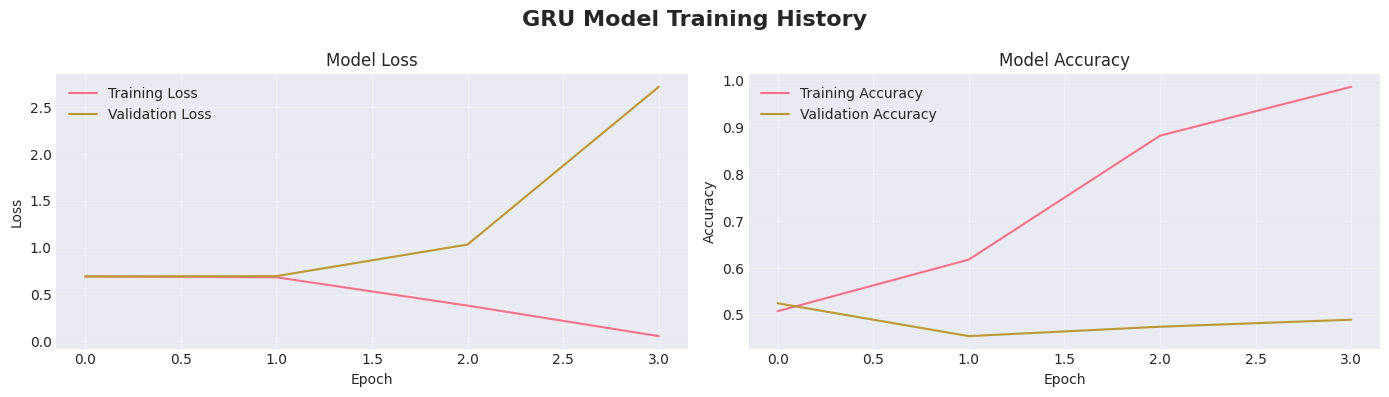

GRU training completed!
Final Training Accuracy: 0.9860
Final Validation Accuracy: 0.4900


In [6]:
# ---- TRAINING GRU MODEL ----
# Persiapan dummy data untuk demo (ganti dengan data real Anda)
X_train = np.random.randint(0, vocab_size, (1000, sequence_length))
y_train = to_categorical(np.random.randint(0, num_classes, 1000), num_classes)

X_val = np.random.randint(0, vocab_size, (200, sequence_length))
y_val = to_categorical(np.random.randint(0, num_classes, 200), num_classes)

# Training dengan callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history_gru = gru_model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

# ---- VISUALIZE GRU TRAINING HISTORY ----
plot_training_history(history_gru, title="GRU Model Training History")

print("GRU training completed!")
print(f"Final Training Accuracy: {history_gru.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history_gru.history['val_accuracy'][-1]:.4f}")


## 3. Attention Mechanism

Template untuk membuat model dengan Attention layer untuk sequence-to-sequence tasks.

**Parameter yang dapat diatur:**
- `sequence_length`: Panjang sequence (default: 100)
- `vocab_size`: Jumlah vocabulary (default: 5000)
- `embedding_dim`: Dimensi embedding (default: 128)
- `lstm_units`: Jumlah unit LSTM (default: 64)
- `num_heads`: Jumlah attention heads (default: 4)
- `batch_size`: Jumlah batch (default: 32)

In [7]:
# ==========================================
# 3. ATTENTION MECHANISM SNIPPET
# ==========================================

# Parameters yang dapat diatur
sequence_length = 100
vocab_size = 5000
embedding_dim = 128
lstm_units = 64
num_heads = 4
batch_size = 32
epochs = 10

# ---- BUILD ATTENTION MODEL ----
def build_attention_model(vocab_size=5000, sequence_length=100,
                         embedding_dim=128, lstm_units=64, 
                         num_heads=4, num_classes=2):
    """Membangun model dengan Multi-Head Attention"""
    inputs = Input(shape=(sequence_length,))
    
    # Embedding
    x = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(inputs)
    
    # LSTM encoder
    encoder_outputs = LSTM(lstm_units, return_sequences=True)(x)
    
    # Multi-Head Attention
    attention_output = MultiHeadAttention(
        num_heads=num_heads,
        key_dim=lstm_units // num_heads
    )(encoder_outputs, encoder_outputs)
    
    # Residual connection
    attention_output = Add()([encoder_outputs, attention_output])
    attention_output = LayerNormalization()(attention_output)
    
    # Global pooling
    x = GlobalAveragePooling1D()(attention_output)
    
    # Dense layers
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu')(x)
    
    # Output
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# ---- COMPILE ATTENTION MODEL ----
attention_model = build_attention_model(
    vocab_size=vocab_size,
    sequence_length=sequence_length,
    embedding_dim=embedding_dim,
    lstm_units=lstm_units,
    num_heads=num_heads
)

attention_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=CategoricalCrossentropy(),
    metrics=['accuracy']
)

print("Attention Model compiled!")
attention_model.summary()


Attention Model compiled!


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 100, 128)  │    640,000 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 100, 64)   │     49,408 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 100, 64)   │     16,640 │ lstm[0][0],       │
│ (MultiHeadAttentio… │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 100, 64)   │          0 │ lstm[0][0],       │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 100, 64)   │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 64)        │      4,160 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 64)        │          0 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 32)        │      2,080 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 2)         │         66 │ dense_11[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 712,482 (2.72 MB)

 Trainable params: 712,482 (2.72 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.5200 - loss: 0.6995 - val_accuracy: 0.4850 - val_loss: 0.7003
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5800 - loss: 0.6732 - val_accuracy: 0.4800 - val_loss: 0.7076
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8290 - loss: 0.4272 - val_accuracy: 0.5100 - val_loss: 0.8615
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9620 - loss: 0.1317 - val_accuracy: 0.4700 - val_loss: 1.8272


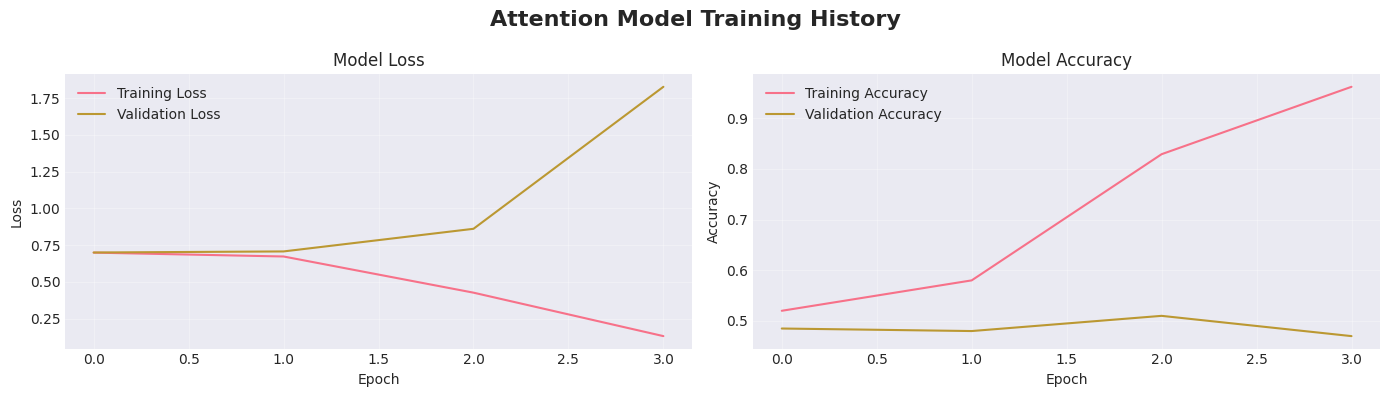

Attention model training completed!
Final Training Accuracy: 0.9620
Final Validation Accuracy: 0.4700


In [8]:
# ---- TRAINING ATTENTION MODEL ----
# Persiapan dummy data
X_train_attn = np.random.randint(0, vocab_size, (1000, sequence_length))
y_train_attn = to_categorical(np.random.randint(0, 2, 1000), 2)

X_val_attn = np.random.randint(0, vocab_size, (200, sequence_length))
y_val_attn = to_categorical(np.random.randint(0, 2, 200), 2)

# Training dengan callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history_attention = attention_model.fit(
    X_train_attn, y_train_attn,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val_attn, y_val_attn),
    callbacks=[early_stopping],
    verbose=1
)

# ---- VISUALIZE ATTENTION TRAINING HISTORY ----
plot_training_history(history_attention, title="Attention Model Training History")

print("Attention model training completed!")
print(f"Final Training Accuracy: {history_attention.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history_attention.history['val_accuracy'][-1]:.4f}")


## 4. Transformer

Template untuk membuat model Transformer dengan encoder-decoder architecture.

**Parameter yang dapat diatur:**
- `sequence_length`: Panjang sequence (default: 100)
- `vocab_size`: Jumlah vocabulary (default: 5000)
- `embedding_dim`: Dimensi embedding (default: 128)
- `num_heads`: Jumlah attention heads (default: 4)
- `ff_dim`: Dimensi feed-forward (default: 256)
- `num_layers`: Jumlah transformer layers (default: 2)
- `batch_size`: Jumlah batch (default: 32)

In [9]:
# ==========================================
# 4. TRANSFORMER SNIPPET
# ==========================================

# Parameters yang dapat diatur
sequence_length = 100
vocab_size = 5000
embedding_dim = 128
num_heads = 4
ff_dim = 256
num_layers = 2
batch_size = 32
epochs = 10

# ---- BUILD TRANSFORMER BLOCK ----
def transformer_block(x, embed_dim, num_heads, ff_dim, rate=0.1):
    """Single Transformer Block dengan attention dan feed-forward"""
    # Multi-head attention
    attn_output = MultiHeadAttention(
        num_heads=num_heads,
        key_dim=embed_dim // num_heads
    )(x, x)
    attn_output = Dropout(rate)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(x + attn_output)
    
    # Feed forward network
    ffn_output = Dense(ff_dim, activation="relu")(out1)
    ffn_output = Dense(embed_dim)(ffn_output)
    ffn_output = Dropout(rate)(ffn_output)
    out2 = LayerNormalization(epsilon=1e-6)(out1 + ffn_output)
    
    return out2

# ---- BUILD TRANSFORMER MODEL ----
def build_transformer_model(vocab_size=5000, sequence_length=100,
                           embedding_dim=128, num_heads=4, 
                           ff_dim=256, num_layers=2, num_classes=2):
    """Membangun Transformer Model"""
    inputs = Input(shape=(sequence_length,))
    
    # Embedding
    x = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(inputs)
    
    # Stack transformer blocks
    for _ in range(num_layers):
        x = transformer_block(x, embedding_dim, num_heads, ff_dim, rate=0.1)
    
    # Global pooling
    x = GlobalAveragePooling1D()(x)
    
    # Dense layers
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='relu')(x)
    
    # Output
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# ---- COMPILE TRANSFORMER MODEL ----
transformer_model = build_transformer_model(
    vocab_size=vocab_size,
    sequence_length=sequence_length,
    embedding_dim=embedding_dim,
    num_heads=num_heads,
    ff_dim=ff_dim,
    num_layers=num_layers
)

transformer_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=CategoricalCrossentropy(),
    metrics=['accuracy']
)

print("Transformer Model compiled!")
transformer_model.summary()


Transformer Model compiled!


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 100, 128)  │    640,000 │ input_layer_5[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 100, 128)  │     66,048 │ embedding_2[0][0… │
│ (MultiHeadAttentio… │                   │            │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 100, 128)  │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 100, 128)  │          0 │ embedding_2[0][0… │
│                     │                   │            │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 128)  │        256 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 100, 256)  │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 100, 128)  │     32,896 │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 100, 128)  │          0 │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 100, 128)  │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 128)  │        256 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 100, 128)  │     66,048 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 100, 128)  │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 100, 128)  │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 128)  │        256 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 100, 256)  │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 100, 128)  │     32,896 │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 100, 128)  │          0 │ dense_16[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 100, 128)  │          0 │ layer_normalizat

 Total params: 915,362 (3.49 MB)

 Trainable params: 915,362 (3.49 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


2025-12-05 09:13:15.952685: I external/local_xla/xla/service/service.cc:163] XLA service 0x75e64c02cc10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-05 09:13:15.952719: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2025-12-05 09:13:16.065936: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-05 09:13:17.399335: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-05 09:13:17.399564: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because

 1/32 ━━━━━━━━━━━━━━━━━━━━ 10:07 20s/step - accuracy: 0.4375 - loss: 0.9120

I0000 00:00:1764900812.720224   13953 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5023 - loss: 0.7351

2025-12-05 09:13:34.367651: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-05 09:13:34.368003: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-05 09:13:35.422561: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_58', 16 bytes spill stores, 16 bytes spill loads

2025-12-05 09:13:35.491577: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : R

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.5013 - loss: 0.7339

2025-12-05 09:13:45.287218: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'fusion_405', 8 bytes spill stores, 8 bytes spill loads



32/32 ━━━━━━━━━━━━━━━━━━━━ 37s 546ms/step - accuracy: 0.4870 - loss: 0.7163 - val_accuracy: 0.4550 - val_loss: 0.7057
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5720 - loss: 0.6752 - val_accuracy: 0.5150 - val_loss: 0.7078
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8530 - loss: 0.3807 - val_accuracy: 0.5050 - val_loss: 0.8941
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9450 - loss: 0.1572 - val_accuracy: 0.4900 - val_loss: 1.6289


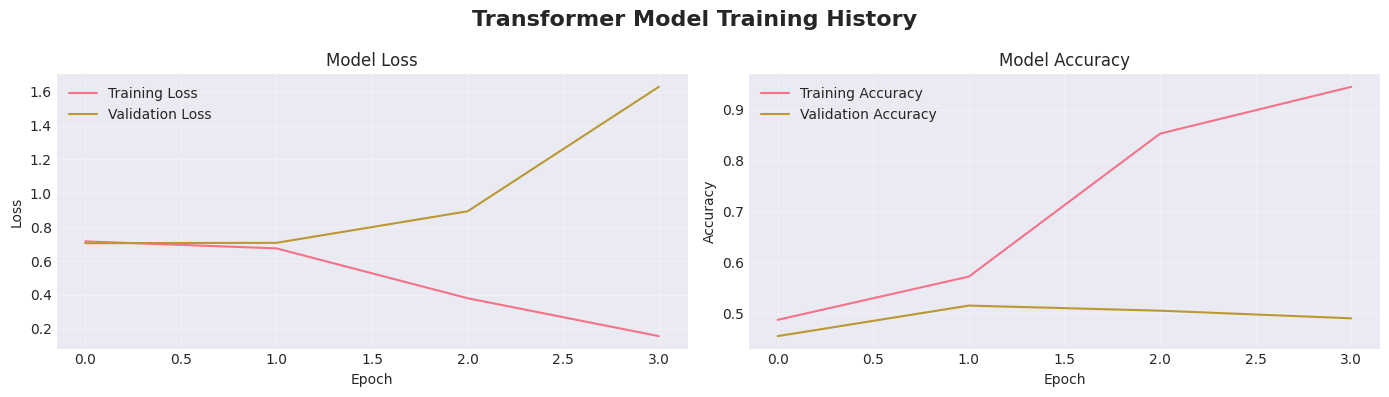

Transformer training completed!
Final Training Accuracy: 0.9450
Final Validation Accuracy: 0.4900


In [10]:
# ---- TRAINING TRANSFORMER MODEL ----
# Persiapan dummy data
X_train_trans = np.random.randint(0, vocab_size, (1000, sequence_length))
y_train_trans = to_categorical(np.random.randint(0, 2, 1000), 2)

X_val_trans = np.random.randint(0, vocab_size, (200, sequence_length))
y_val_trans = to_categorical(np.random.randint(0, 2, 200), 2)

# Training dengan callbacks
checkpoint = ModelCheckpoint(
    'transformer_best.keras',
    monitor='val_accuracy',
    save_best_only=True
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history_transformer = transformer_model.fit(
    X_train_trans, y_train_trans,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val_trans, y_val_trans),
    callbacks=[checkpoint, early_stopping],
    verbose=1
)

# ---- VISUALIZE TRANSFORMER TRAINING HISTORY ----
plot_training_history(history_transformer, title="Transformer Model Training History")

print("Transformer training completed!")
print(f"Final Training Accuracy: {history_transformer.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history_transformer.history['val_accuracy'][-1]:.4f}")


## Comparison & Summary

Perbandingan semua model yang telah dibuat

MODEL COMPARISON

Model           Parameters           Structure
----------------------------------------------------------------------
GRU             708514               Embedding + 2x GRU + Dense
Attention       712482               Embedding + LSTM + MultiHeadAttn
Transformer     915362               Embedding + 2x TransformerBlk


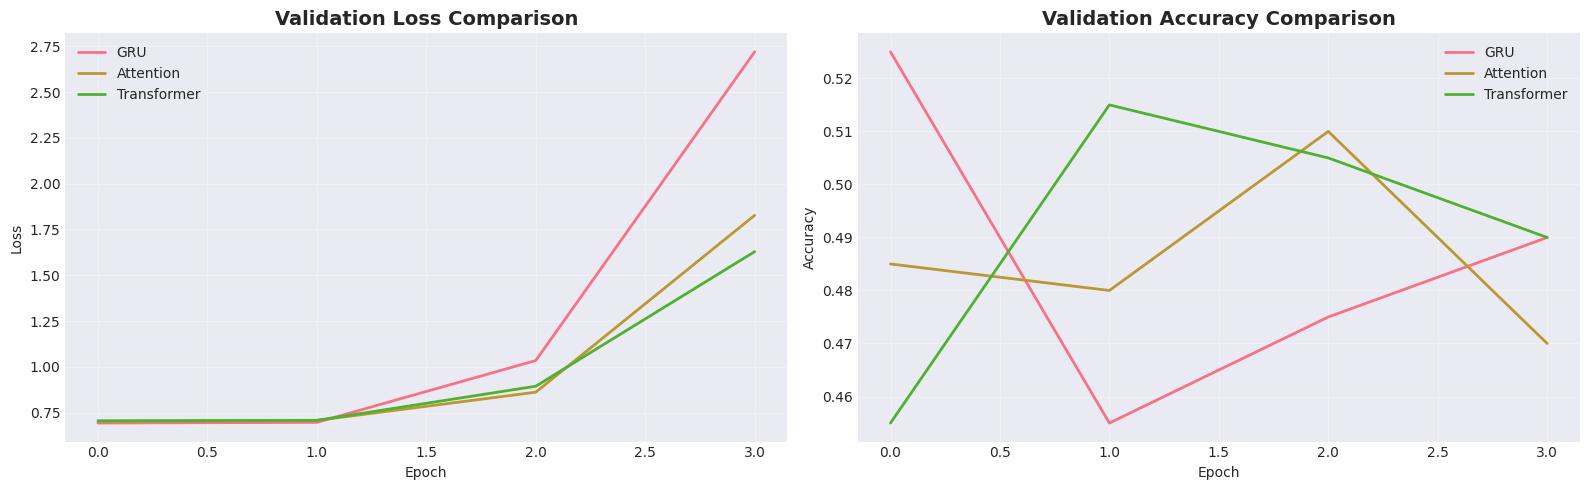


PENGGUNAAN MODEL:

1. GRU - Cocok untuk:
   - Sequence classification
   - Time series prediction
   - Text processing (lebih ringan dari Transformer)

2. Attention - Cocok untuk:
   - Fokus pada bagian penting sequence
   - Machine translation
   - Question answering

3. Transformer - Cocok untuk:
   - Parallel processing
   - Long-range dependencies
   - NLP tasks (BERT, GPT-like)
   - Memerlukan komputasi lebih tinggi



In [11]:
# ==========================================
# MODEL COMPARISON
# ==========================================

# Kumpulkan hasil semua model (jika semua sudah dilatih)
models_comparison = {
    'GRU': {
        'params': gru_model.count_params(),
        'history': history_gru if 'history_gru' in locals() else None
    },
    'Attention': {
        'params': attention_model.count_params(),
        'history': history_attention if 'history_attention' in locals() else None
    },
    'Transformer': {
        'params': transformer_model.count_params(),
        'history': history_transformer if 'history_transformer' in locals() else None
    }
}

print("=" * 70)
print("MODEL COMPARISON")
print("=" * 70)
print(f"\n{'Model':<15} {'Parameters':<20} {'Structure'}")
print("-" * 70)
print(f"{'GRU':<15} {gru_model.count_params():<20} Embedding + 2x GRU + Dense")
print(f"{'Attention':<15} {attention_model.count_params():<20} Embedding + LSTM + MultiHeadAttn")
print(f"{'Transformer':<15} {transformer_model.count_params():<20} Embedding + {num_layers}x TransformerBlk")

# Visualisasi perbandingan training history
if 'history_gru' in locals() and 'history_attention' in locals() and 'history_transformer' in locals():
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # Loss comparison
    axes[0].plot(history_gru.history['val_loss'], label='GRU', linewidth=2)
    axes[0].plot(history_attention.history['val_loss'], label='Attention', linewidth=2)
    axes[0].plot(history_transformer.history['val_loss'], label='Transformer', linewidth=2)
    axes[0].set_title('Validation Loss Comparison', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Accuracy comparison
    axes[1].plot(history_gru.history['val_accuracy'], label='GRU', linewidth=2)
    axes[1].plot(history_attention.history['val_accuracy'], label='Attention', linewidth=2)
    axes[1].plot(history_transformer.history['val_accuracy'], label='Transformer', linewidth=2)
    axes[1].set_title('Validation Accuracy Comparison', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("\n" + "=" * 70)
print("PENGGUNAAN MODEL:")
print("=" * 70)
print("""
1. GRU - Cocok untuk:
   - Sequence classification
   - Time series prediction
   - Text processing (lebih ringan dari Transformer)

2. Attention - Cocok untuk:
   - Fokus pada bagian penting sequence
   - Machine translation
   - Question answering

3. Transformer - Cocok untuk:
   - Parallel processing
   - Long-range dependencies
   - NLP tasks (BERT, GPT-like)
   - Memerlukan komputasi lebih tinggi
""")


## 5. Simple Neural Network (NN)

Template untuk membuat Neural Network sederhana untuk classification dan regression.

**Parameter yang dapat diatur:**
- `input_dim`: Dimensi input data (jumlah fitur)
- `hidden_layers`: List ukuran hidden layers (default: [64, 32])
- `num_classes`: Jumlah kelas output (default: 2)
- `activation`: Fungsi aktivasi (default: 'relu')
- `learning_rate`: Learning rate (default: 0.001)
- `batch_size`: Jumlah batch (default: 32)
- `epochs`: Jumlah epoch training (default: 50)

In [12]:
# ==========================================
# 5. SIMPLE NEURAL NETWORK SNIPPET
# ==========================================

# Parameters yang dapat diatur
input_dim = 20          # Jumlah fitur input
hidden_layers = [64, 32, 16]  # Ukuran hidden layers
num_classes = 2         # Jumlah kelas output
activation = 'relu'     # Fungsi aktivasi
learning_rate = 0.001   # Learning rate
batch_size = 32         # Batch size
epochs_nn = 50          # Jumlah epoch

# ---- BUILD SIMPLE NN MODEL ----
def build_simple_nn(input_dim, hidden_layers=[64, 32], 
                    num_classes=2, activation='relu', dropout_rate=0.3):
    """
    Membangun Simple Neural Network
    
    Args:
        input_dim: Dimensi input (jumlah fitur)
        hidden_layers: List ukuran hidden layers
        num_classes: Jumlah kelas output
        activation: Fungsi aktivasi ('relu', 'tanh', 'sigmoid', 'leaky_relu')
        dropout_rate: Dropout rate untuk regularisasi
    """
    model = Sequential()
    
    # Input layer + first hidden layer
    model.add(Dense(hidden_layers[0], input_dim=input_dim))
    if activation == 'leaky_relu':
        model.add(LeakyReLU(alpha=0.1))
    else:
        model.add(Activation(activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Hidden layers
    for units in hidden_layers[1:]:
        model.add(Dense(units))
        if activation == 'leaky_relu':
            model.add(LeakyReLU(alpha=0.1))
        else:
            model.add(Activation(activation))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
    
    # Output layer
    if num_classes == 2:
        # Binary classification
        model.add(Dense(1, activation='sigmoid'))
    else:
        # Multi-class classification
        model.add(Dense(num_classes, activation='softmax'))
    
    return model

# ---- BUILD REGRESSION NN MODEL ----
def build_regression_nn(input_dim, hidden_layers=[64, 32], 
                        activation='relu', dropout_rate=0.2):
    """
    Membangun Neural Network untuk Regression
    """
    model = Sequential()
    
    # Input + hidden layers
    model.add(Dense(hidden_layers[0], input_dim=input_dim, activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    for units in hidden_layers[1:]:
        model.add(Dense(units, activation=activation))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
    
    # Output layer (linear untuk regression)
    model.add(Dense(1, activation='linear'))
    
    return model

# ---- CREATE CLASSIFICATION MODEL ----
nn_classifier = build_simple_nn(
    input_dim=input_dim,
    hidden_layers=hidden_layers,
    num_classes=num_classes,
    activation=activation,
    dropout_rate=0.3
)

# ---- COMPILE CLASSIFICATION MODEL ----
if num_classes == 2:
    nn_classifier.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
else:
    nn_classifier.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

print("Simple NN Classifier compiled!")
nn_classifier.summary()


Simple NN Classifier compiled!


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 64)             │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,417 (17.25 KB)

 Trainable params: 4,193 (16.38 KB)

 Non-trainable params: 224 (896.00 B)

Epoch 1/50
15/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4757 - loss: 1.0568 
Epoch 1: val_accuracy improved from None to 0.52000, saving model to simple_nn_best.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.5325 - loss: 0.8993 - val_accuracy: 0.5200 - val_loss: 0.7404
Epoch 2/50
15/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6335 - loss: 0.7059 
Epoch 2: val_accuracy improved from 0.52000 to 0.69500, saving model to simple_nn_best.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6300 - loss: 0.6836 - val_accuracy: 0.6950 - val_loss: 0.5647
Epoch 3/50
14/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7011 - loss: 0.5772 
Epoch 3: val_accuracy improved from 0.69500 to 0.74000, saving model to simple_nn_best.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6662 - loss: 0.6061 - val_accuracy: 0.7400 - val_loss: 0.4999
Epoch 4/50
16/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6960 - loss: 0.6193 
Epoch 4: val_accuracy improved from 0.

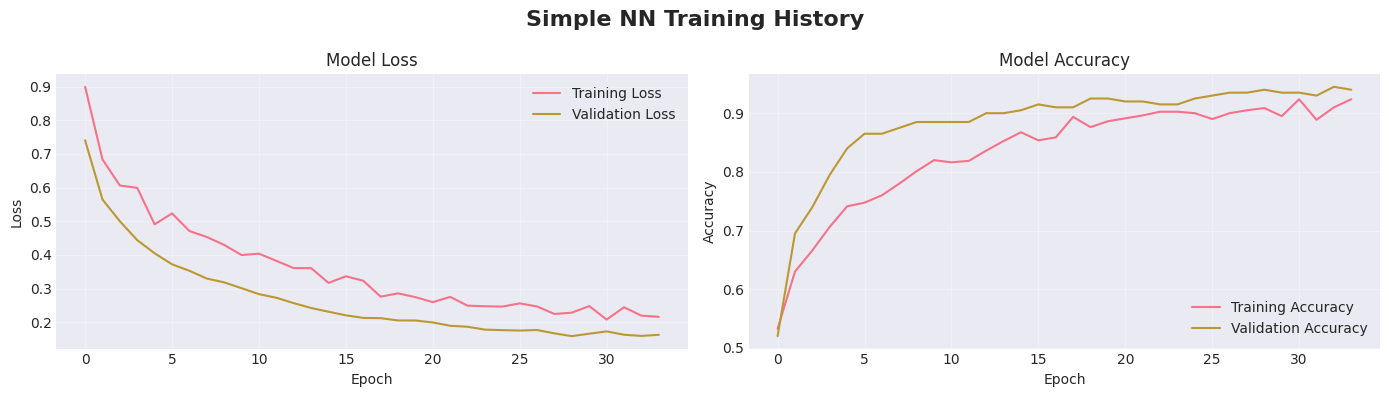


SIMPLE NN EVALUATION
Training   - Loss: 0.1134, Accuracy: 0.9688
Validation - Loss: 0.1589, Accuracy: 0.9400


In [13]:
# ---- TRAINING SIMPLE NN ----
# Persiapan dummy data untuk Classification
from sklearn.datasets import make_classification, make_regression
from sklearn.model_selection import train_test_split

# Generate classification data
X_class, y_class = make_classification(
    n_samples=1000,
    n_features=input_dim,
    n_informative=15,
    n_redundant=5,
    n_classes=num_classes,
    random_state=42
)

# Split data
X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(
    X_class, y_class, test_size=0.2, random_state=42
)

# Training dengan callbacks
early_stopping_nn = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

checkpoint_nn = ModelCheckpoint(
    'simple_nn_best.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# Training
history_nn = nn_classifier.fit(
    X_train_nn, y_train_nn,
    batch_size=batch_size,
    epochs=epochs_nn,
    validation_data=(X_val_nn, y_val_nn),
    callbacks=[early_stopping_nn, checkpoint_nn],
    verbose=1
)

# ---- VISUALIZE NN TRAINING HISTORY ----
plot_training_history(history_nn, title="Simple NN Training History")

# ---- EVALUATION ----
train_loss, train_acc = nn_classifier.evaluate(X_train_nn, y_train_nn, verbose=0)
val_loss, val_acc = nn_classifier.evaluate(X_val_nn, y_val_nn, verbose=0)

print(f"\n{'='*50}")
print("SIMPLE NN EVALUATION")
print(f"{'='*50}")
print(f"Training   - Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
print(f"Validation - Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")



REGRESSION NEURAL NETWORK
NN Regressor compiled!


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 64)             │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,417 (17.25 KB)

 Trainable params: 4,193 (16.38 KB)

 Non-trainable params: 224 (896.00 B)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 55361.6836 - mae: 189.7296 - val_loss: 51130.2109 - val_mae: 184.2196
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 55087.1836 - mae: 189.3040 - val_loss: 51003.0352 - val_mae: 184.0031
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 54724.1094 - mae: 188.6537 - val_loss: 50761.0352 - val_mae: 183.5707
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 54315.3750 - mae: 187.8822 - val_loss: 50343.9805 - val_mae: 182.7975
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 53843.9766 - mae: 187.0271 - val_loss: 49808.4062 - val_mae: 181.7648
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 53381.2344 - mae: 186.1224 - val_loss: 49146.3281 - val_mae: 180.4540
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 52970.4492 - mae: 185.4065 - val_loss: 48470.9141 - val_mae: 179.0945
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 52515.9688 - mae: 184.4123 - val_loss: 47837.

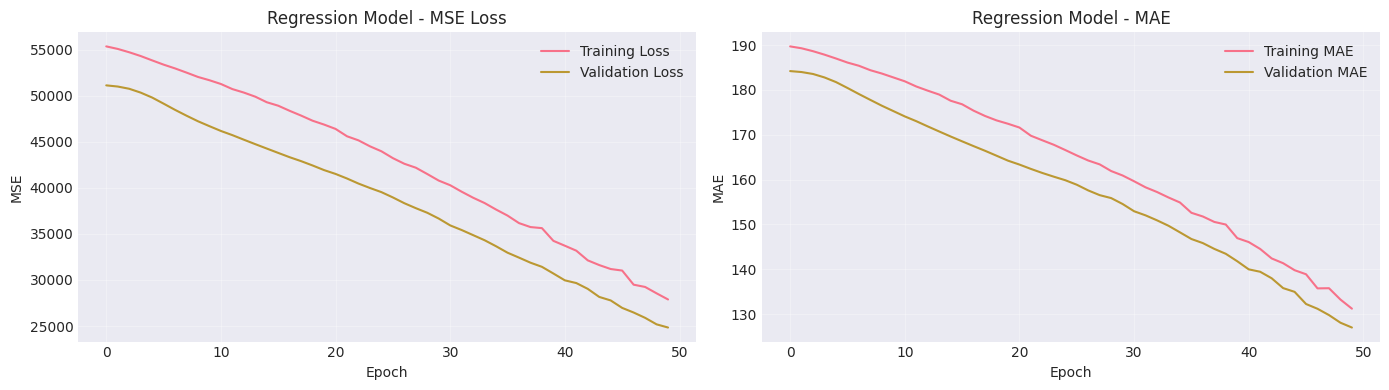


REGRESSION NN EVALUATION
Training   - MSE: 27031.0020, MAE: 130.7270
Validation - MSE: 24837.8203, MAE: 127.0010


In [14]:
# ---- REGRESSION NEURAL NETWORK ----
print("\n" + "="*60)
print("REGRESSION NEURAL NETWORK")
print("="*60)

# Generate regression data
X_reg, y_reg = make_regression(
    n_samples=1000,
    n_features=input_dim,
    n_informative=15,
    noise=10,
    random_state=42
)

# Split data
X_train_reg, X_val_reg, y_train_reg, y_val_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

# Build regression model
nn_regressor = build_regression_nn(
    input_dim=input_dim,
    hidden_layers=[64, 32, 16],
    activation='relu',
    dropout_rate=0.2
)

# Compile regression model
nn_regressor.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',           # Mean Squared Error untuk regression
    metrics=['mae']       # Mean Absolute Error
)

print("NN Regressor compiled!")
nn_regressor.summary()

# Training regression
history_reg = nn_regressor.fit(
    X_train_reg, y_train_reg,
    batch_size=32,
    epochs=50,
    validation_data=(X_val_reg, y_val_reg),
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
    verbose=1
)

# Visualize regression training
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Plot MSE Loss
axes[0].plot(history_reg.history['loss'], label='Training Loss')
axes[0].plot(history_reg.history['val_loss'], label='Validation Loss')
axes[0].set_title('Regression Model - MSE Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MSE')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot MAE
axes[1].plot(history_reg.history['mae'], label='Training MAE')
axes[1].plot(history_reg.history['val_mae'], label='Validation MAE')
axes[1].set_title('Regression Model - MAE')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Evaluation
train_mse, train_mae = nn_regressor.evaluate(X_train_reg, y_train_reg, verbose=0)
val_mse, val_mae = nn_regressor.evaluate(X_val_reg, y_val_reg, verbose=0)

print(f"\n{'='*50}")
print("REGRESSION NN EVALUATION")
print(f"{'='*50}")
print(f"Training   - MSE: {train_mse:.4f}, MAE: {train_mae:.4f}")
print(f"Validation - MSE: {val_mse:.4f}, MAE: {val_mae:.4f}")


In [15]:
# ==========================================
# QUICK REFERENCE - SIMPLE NN
# ==========================================
print("""
╔══════════════════════════════════════════════════════════════════╗
║           QUICK REFERENCE - SIMPLE NEURAL NETWORK                ║
╠══════════════════════════════════════════════════════════════════╣
║                                                                  ║
║  1. CLASSIFICATION:                                              ║
║     - Output: Dense(num_classes, activation='softmax')           ║
║     - Loss: 'categorical_crossentropy' atau 'sparse_...'         ║
║     - Binary: Dense(1, activation='sigmoid')                     ║
║              Loss: 'binary_crossentropy'                         ║
║     - Metrics: ['accuracy']                                      ║
║                                                                  ║
║  2. REGRESSION:                                                  ║
║     - Output: Dense(1, activation='linear')                      ║
║     - Loss: 'mse' (Mean Squared Error)                           ║
║     - Metrics: ['mae'] (Mean Absolute Error)                     ║
║                                                                  ║
║  3. AKTIVASI UMUM:                                               ║
║     - 'relu'      : ReLU (default, fast)                         ║
║     - 'leaky_relu': LeakyReLU (untuk vanishing gradient)         ║
║     - 'tanh'      : Range [-1, 1]                                ║
║     - 'sigmoid'   : Range [0, 1]                                 ║
║     - 'softmax'   : Probabilitas multi-class                     ║
║                                                                  ║
║  4. OPTIMIZER:                                                   ║
║     - Adam(lr=0.001)   : Default, bagus untuk umumnya            ║
║     - SGD(lr=0.01)     : Simple, bisa dengan momentum            ║
║     - RMSprop(lr=0.001): Bagus untuk RNN                         ║
║                                                                  ║
║  5. REGULARISASI:                                                ║
║     - Dropout(0.2-0.5)  : Mencegah overfitting                   ║
║     - BatchNormalization: Stabilkan training                     ║
║     - L2 regularization : kernel_regularizer=l2(0.01)            ║
║                                                                  ║
║  6. CALLBACKS:                                                   ║
║     - EarlyStopping    : Stop jika tidak improve                 ║
║     - ModelCheckpoint  : Save model terbaik                      ║
║     - ReduceLROnPlateau: Kurangi LR jika stuck                   ║
║                                                                  ║
╚══════════════════════════════════════════════════════════════════╝
""")



╔══════════════════════════════════════════════════════════════════╗
║           QUICK REFERENCE - SIMPLE NEURAL NETWORK                ║
╠══════════════════════════════════════════════════════════════════╣
║                                                                  ║
║  1. CLASSIFICATION:                                              ║
║     - Output: Dense(num_classes, activation='softmax')           ║
║     - Loss: 'categorical_crossentropy' atau 'sparse_...'         ║
║     - Binary: Dense(1, activation='sigmoid')                     ║
║              Loss: 'binary_crossentropy'                         ║
║     - Metrics: ['accuracy']                                      ║
║                                                                  ║
║  2. REGRESSION:                                                  ║
║     - Output: Dense(1, activation='linear')                      ║
║     - Loss: 'mse' (Mean Squared Error)                           ║
║     - Metrics: ['mae'] (Mean Ab